In [1]:
import numpy as np
import torch
from matplotlib import pyplot as plt

from collections import defaultdict, namedtuple, deque
import random
from tqdm.notebook import tqdm

In [2]:
class linear_model(torch.nn.Module):
    def __init__(self, input_dim, output_dim):
        super(linear_model, self).__init__()
        self.w = torch.nn.Parameter(torch.zeros(input_dim, output_dim))
        self.b = torch.nn.Parameter(torch.zeros(output_dim))

    def forward(self, x):
        return torch.mm(x, self.w) + self.b.unsqueeze(0)

In [3]:
def x2vec(x):
    vec = np.zeros(11)
    vec[x] = 1
    return vec

def vec2x(vec):
    return np.argmax(vec)

def state_vec(s, s0):
    return torch.tensor(x2vec(s)).unsqueeze(0).to(torch.float)

In [4]:
def next_state(t, a):
    s, s0 = t
    if a == 0:
        s_next = s * 2
    elif a == 1:
        s_next = s + 1
    elif a == 2:
        s_next = s
    elif a == 3:
        s_next = s - 1
    elif a == 4:
        s_next = s // 2
    s_next = max(0, min(10, s_next))
    return (s_next, s0)

In [5]:
def reward_func(t, t_next, done, T):
    s, s0 = t
    s_next, _ = t_next
    if done and s_next != T:
        return -100
    elif done:
        return 100
    return -1

In [6]:
def step(t, a, T):
    t_next = next_state(t, a)
    done = (a == 2)
    r = reward_func(t, t_next, done, T)
    return t_next, r, done 

In [7]:
def update(Qnet, batch, lr=0.1, gamma=0.9):
    loss_fn = torch.nn.MSELoss()
    optimizer = torch.optim.SGD(Qnet.parameters(), lr=lr)
    x, y = [], []
    for e in batch:
        u = state_vec(e.s[0], e.s[1])
        est = Qnet(u)[0, e.a]
        v = e.r
        if not e.d:
            u_next = state_vec(e.ns[0], e.ns[1])
            with torch.no_grad():
                v += gamma * torch.max(Qnet(u_next)[0])
        x.append(est)
        y.append(v)
    x = torch.stack(x)
    y = torch.tensor(y)
    optimizer.zero_grad()
    loss = loss_fn(x, y)
    loss.backward()
    optimizer.step()

In [19]:
def f(x):
    return 0

Experience = namedtuple('Experience', ('s', 'a', 'ns', 'r', 'd'))
starts=list(range(11))

def trial(seed=100, try_num=100000, lr=0.01, eps=0.1):
    # training
    np.random.seed(seed)
    random.seed(seed)
    Qnet = linear_model(input_dim=11, output_dim=5)
    R = []
    experiences = deque(maxlen=1024)
    
    for itr in tqdm(range(try_num)):
        Ri = 0
        s0 = np.random.choice(starts)
        T = f(s0)
        t = (s0, s0)
        for _ in range(1000):
            # 行動を選択
            u = state_vec(t[0], t[1])
            with torch.no_grad():
                a = torch.argmax(Qnet(u)[0]).item() if np.random.rand() >= eps else np.random.randint(5)
            t_next, r, d = step(t, a, T)
            e = Experience(t, a, t_next, r, d)
            experiences.append(e)
            t = t_next
            Ri = Ri + r
            if d:
                break
        if len(experiences) == 1024:
            batch = random.sample(experiences, 32)
            update(Qnet, batch, lr=lr, gamma=0.9)

        R.append(Ri)
    return Qnet, R

In [20]:
Qnet, R = trial(seed=0, eps=0.1, try_num=10000, lr=0.01)

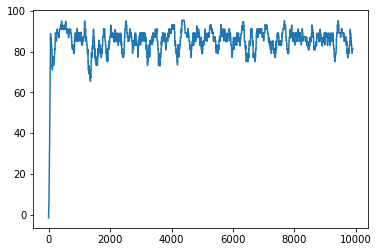

In [21]:
def moving_average(a, n=3):
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

plt.plot(moving_average(R, n=100))
plt.show()

In [22]:
def test(Qnet):
    solved = []
    for s0 in range(11):
        T = f(s0)
        t = (s0, s0)
        for _ in range(100):
            u = state_vec(t[0], t[1])
            with torch.no_grad():
                a = torch.argmax(Qnet(u)[0]).item()
            if a == 2:
                break
            t = next_state(t, a)
        if t[0] == T:
            solved.append((s0, T, 'solved!'))
        else:
            solved.append((s0, T, '-'))
    for item in solved:
        print('init = %d, T = %d, %s' % item)

In [23]:
test(Qnet)

init = 0, T = 0, solved!
init = 1, T = 0, solved!
init = 2, T = 0, solved!
init = 3, T = 0, solved!
init = 4, T = 0, solved!
init = 5, T = 0, solved!
init = 6, T = 0, solved!
init = 7, T = 0, solved!
init = 8, T = 0, solved!
init = 9, T = 0, solved!
init = 10, T = 0, solved!
